In [47]:
import jax
import tax
import clu
import rlax
import tqdm
import haiku as hk
import numpy as np
import collections 
import jax.numpy as jnp
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
os.environ['JAX_CHECK_TRACER_LEAKS'] = '1'
import typing
import optax
import chex
import tree
import mbrl
from jax import jit
from jax import vmap
from functools import partial
from torch.utils.data import DataLoader
from mbrl.common.nn import mlp_deterministic, mlp_multivariate_normal_diag
from mbrl.envs.oracle.pendulum import render, step, reset, env_params, angle_normalize, get_obs_pendulum
from mbrl.algs.rs import trajectory_search, forecast, score, plan

Environment = collections.namedtuple('Environment', ['step', 'reset']) 
tax.set_platform('cpu')
NUM_ENSEMBLE = 4

In [48]:
@jit
def pendulum_reward(observation, u, params):
    th = observation[0] / observation[1]
    th = jnp.arccos(observation[0])
    thdot = observation[2]
    u = jnp.clip(u, -params["max_torque"], params["max_torque"])
    costs = angle_normalize(th) ** 2 + 0.1 * thdot ** 2 + 0.001 * (u ** 2)
    return -costs[0].squeeze()

reward_fn = {
    'pendulum': jit(partial(pendulum_reward, params=env_params))
}

rng = jax.random.PRNGKey(10)
env = Environment(
    jit(lambda state, u: step(env_params, state, u)), 
    jit(reset)
)

action_size = 1
observation_size = 3
env_state, observation = env.reset(rng)

action = jnp.zeros((action_size))
env_state_next, true_Y, true_R, *_ = env.step(env_state, action)

def true_world(carry, t):
    keys, (env_state, observation), trajectory = carry
    action = trajectory[t]
    env_state_next, observation_next, reward, terminal, info = \
        env.step(env_state, action)
    carry = keys, (env_state_next, observation_next), trajectory
    return carry, {
        "observation": observation,
        "observation_next": observation_next,
        "reward": reward, "action": action, "terminal": 1 - terminal,
        "env_state": env_state, 'env_state_next': env_state_next
    }

# Replay buffer

rb = [tax.ReplayBuffer(50_000) for _ in range(NUM_ENSEMBLE)]
rb = tax.AggregatorReplayBuffer(rb)

In [49]:
# Random
buf = []

for _ in range(10):
    score = 0
    env_state, observation = env.reset(rng)
    for _ in range(200):
        rng, key = jax.random.split(rng)
        action = jax.random.uniform(key, (1,), minval=-2., maxval=2.)
        env_state, observation_next, reward, terminal, info = env.step(env_state, action)
        score += reward
        buf.append({
            'observation': observation,
            'observation_next': observation_next,
            'action': action,
            'reward': reward,
            'env_state': env_state,
            'env_state_next': env_state_next
        })
        observation = observation_next.copy()

    print(f'Random Score: {score}')
    
data = tax.reduce(buf)
data = tree.map_structure(lambda v: np.array(v), data)
rb.add(**data)

Random Score: -1176.3677978515625
Random Score: -962.1798095703125
Random Score: -996.4786987304688
Random Score: -1703.94140625
Random Score: -833.6911010742188
Random Score: -1072.240966796875
Random Score: -1067.98828125
Random Score: -995.6116943359375
Random Score: -887.7622680664062
Random Score: -1183.324951171875


# Ensemble Model

In [50]:
FLAGS_MODEL = 'P'
NUM_ENSEMBLE = 4

@chex.dataclass
class NormalizationState:
    observation_mean: jnp.ndarray
    observation_std: jnp.ndarray
    action_mean: jnp.ndarray
    action_std: jnp.ndarray

        
@chex.dataclass
class FState:
    params: typing.Any
    opt_state: typing.Any
    norm: NormalizationState

        
state_norm = NormalizationState(
    observation_mean = jnp.zeros((NUM_ENSEMBLE, observation_size,)),
    observation_std = jnp.ones((NUM_ENSEMBLE, observation_size,)),
    action_mean = jnp.zeros((NUM_ENSEMBLE, action_size,)),
    action_std = jnp.ones((NUM_ENSEMBLE, action_size,)),
)


if FLAGS_MODEL == 'D':
    fmodel = lambda x, a: mlp_deterministic(
        observation_size, [128, 128], 
        final_tanh_activation=False)(jnp.concatenate([x, a], -1))
elif FLAGS_MODEL == 'P':
    fmodel = lambda x, a: mlp_multivariate_normal_diag(
        observation_size, [128, 128], 
        use_tanh_bijector=False)(jnp.concatenate([x, a], -1))
else:
    raise NotImplementedError()
    
fmodel = hk.transform(fmodel)
fmodel = hk.without_apply_rng(fmodel)
vrng = jax.random.split(rng, NUM_ENSEMBLE)
fmodel_params = vmap(fmodel.init, (0, None, None))(vrng, jnp.zeros((observation_size,)), jnp.zeros((action_size,)))
fmodel_opt = optax.adabelief(learning_rate=1e-3)
fmodel_opt_state = vmap(fmodel_opt.init)(fmodel_params)

fstate = FState(params=fmodel_params, opt_state=fmodel_opt_state, norm=state_norm)

if 'D' in FLAGS_MODEL:
    @partial(jit, static_argnums=(3, 4))
    def loss_fn(p, inputs, target, fmodel_def, type_loss: str = 'l1'):
        prediction = fmodel_def(p, *inputs)
        if type_loss == 'l1':
            loss = tax.l1_loss(prediction, target)
        loss = tax.l2_loss(prediction, target)
        loss = loss.mean()
        return loss

   
if 'P' in FLAGS_MODEL:
    @partial(jit, static_argnums=(3,))
    def loss_fn(p, inputs, target, fmodel_def):
        dist = fmodel_def(p, *inputs)
        loss = -dist.log_prob(target).mean()
        return loss

    
@partial(jit, static_argnums=(3, 4))
def update_fn(state, inputs, target, opt, loss_fn):
    l, g = jax.value_and_grad(loss_fn)(state.params, inputs, target)
    updates, opt_state = opt.update(g, state.opt_state)
    params = jax.tree_multimap(lambda p, u: p + u, state.params, updates)
    state = state.replace(params=params, opt_state=opt_state)
    metrics = {'loss': l}
    return state, metrics
  

loss   = jit(partial(loss_fn, fmodel_def=fmodel.apply))
update = jit(vmap(partial(update_fn, loss_fn=loss, opt=fmodel_opt), (0, 1, 1)))
vmap_loss = jit(vmap(loss, (0, 1, 1)))

In [51]:
ds = rb.dataset()
ds = tax.reduce(ds, np.stack, dict(axis=1))


In [64]:
def train_fmodel(
    data, state, loss_fn, update_fn,
    forward_model,
    seed: int = 42, batch_size:int = 32, 
    use_norm: bool = True, use_residual: bool = True,
    max_epochs: int = 200, validation_size: float = 0.25,
    early_stopping_patience: int = 15, alpha_norm: float = 0.5,
):
    # Assume that the initial normalization is (mean=0, std=1)
    # This setting correspond to no normalization.
    # If the flag `use_norm` is True, the function
    # will update the norm state based on the data
    # it received according a polyak rule (weighted update).
    if use_norm:
        observation_mean = data['observation'].mean(0)
        observation_std = data['observation'].std(0)
        action_mean = data['action'].mean(0)
        action_std = data['action'].std(0)
        new_observation_mean = (1-alpha_norm) * observation_mean + \
                             alpha_norm * state.norm.observation_mean
        new_observation_std = (1-alpha_norm) * observation_std + \
                             alpha_norm * state.norm.observation_std
        new_action_mean = (1-alpha_norm) * action_mean + \
                             alpha_norm * state.norm.action_mean        
        new_action_std = (1-alpha_norm) * action_std + \
                             alpha_norm * state.norm.action_std
    
        new_norm = NormalizationState(
            observation_mean=new_observation_mean,
            observation_std=new_observation_std,
            action_mean=new_action_mean,
            action_std=new_action_std
        )
        state = state.replace(norm=new_norm)
        
        
    def process(observation, action, observation_next):
        observation_norm = (observation - state.norm.observation_mean) / (state.norm.observation_std + 1e-6)
        action_norm = (action - state.norm.action_mean) / (state.norm.action_std + 1e-6)
        inputs = (observation_norm, action_norm)
        target = observation_next
        if use_residual:
            target = observation_next - observation
        return inputs, target
    
    ds = tax.DatasetDict(data)
    es = tax.EarlyStopping(patience=early_stopping_patience)
    ds_train, ds_valid = tax.random_splits(ds, validation_size)
    dl_train = DataLoader(ds_train, batch_size=batch_size, shuffle=True)
    dl_valid = DataLoader(ds_valid, batch_size=batch_size)
    
    allinfo = []
    t = tqdm.trange(max_epochs)
    for range in t:
        store = tax.Store(decimals=4)
        for batch in dl_train:
            batch = tree.map_structure(lambda v: jnp.asarray(v), batch)
            action = batch['action']
            observation = batch['observation']
            observation_next = batch['observation_next']
            inputs, target = process(observation, action, observation_next)
            state, info = update_fn(state, inputs, target)
            store.add(**{'loss/train': info['loss'].mean()})
        
        for batch in dl_valid:
            batch = tree.map_structure(lambda v: jnp.asarray(v), batch)
            action = batch['action']
            observation = batch['observation']
            observation_next = batch['observation_next']
            inputs, target = process(observation, action, observation_next)
            l  = loss_fn(state.params, inputs, target)
            store.add(**{'loss/valid': l.mean()})
    
        metrics = store.get()
        t.set_postfix(metrics)
        allinfo.append(metrics)
        validation_loss = metrics['loss/valid']
        if es.step(validation_loss):
            break
        
    return state, metrics
        
train = partial(train_fmodel, loss_fn=vmap_loss, update_fn=update,
                seed = 42, batch_size= 32, 
                forward_model = jit(vmap(fmodel.apply, (0, 0, 0))),
                use_norm = True, use_residual= True,
                max_epochs = 500, validation_size = 0.25,
                early_stopping_patience = 10, alpha_norm = 0.5)

fstate, info = train(ds, fstate)

  5%|▌         | 27/500 [00:02<00:44, 10.61it/s, loss/train=-9.82, loss/valid=-10]  


In [77]:
# Sanity Check to automatically choose the right
# inference model. We only choose the first member of the
# ensemble for this test.

A = ds['action'][0, :]
X = ds['observation'][0, :]
Y = ds['observation_next'][0, :]
vmap_fmodel = vmap(fmodel.apply, (0, 0, 0))
dummy_prediction = vmap_fmodel(fstate.params, X, A)

model = 'P'
if isinstance(dummy_prediction, jnp.ndarray):
    model = 'D'

    
use_residual = True
# At this point, the training is done.
# We return the state, the metrics
# and the forward model inference ready 
# to use according the training.
@jit
def fmodel_inference(rng, observation, action, state):
    observation_norm = (observation - state.norm.observation_mean) / (state.norm.observation_std + 1e-6)
    action_norm = (action - state.norm.action_mean) / (state.norm.action_std + 1e-6)

    if model == 'D':
        prediction = vmap_fmodel(state.params, observation_norm, action_norm)
        raise
    elif model == 'P':
        prediction = vmap_fmodel(state.params, observation_norm, action_norm).loc.val
    else:
        raise NotImplementedError()
    prediction = prediction.mean(0)
    if use_residual:
        return prediction + observation
    return prediction

fmodel_inference_ = jit(partial(fmodel_inference, state=fstate))

In [78]:
fmodel_inference_(None, X, A).shape

(4, 3)

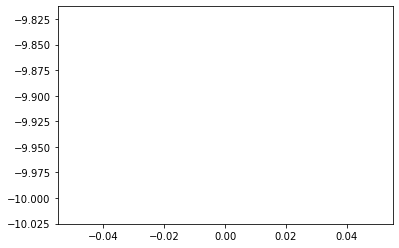

In [79]:
plt.plot(info['loss/train'])
plt.plot(info['loss/valid'])

In [80]:
from mbrl.algs.rs import trajectory_search, forecast, score, plan

# In pendulum.
@jit
def world(carry, t):
    keys, (env_state, observation), trajectory = carry
    action = trajectory[t]
    # -- Forward Model
    observation_next = fmodel_inference_(rng, observation, action)
    # -- Ground Truth (reward/observation from model)
    reward = reward_fn['pendulum'](observation, action)
    terminal = False
    carry = keys, (env_state, observation_next), trajectory
    return carry, {
        "observation": observation,
        "observation_next": observation_next,
        "reward": reward, "action": action, "terminal": 1 - terminal,
        "env_state": env_state, 'env_state_next': env_state_next,
        #'delta_env_state_next': rlax.l2_loss(env_state_next_pred - env_state_next).mean(),
        #'env_state_next_pred': env_state_next_pred
    }

In [84]:
score_ = jit(partial(score, terminal_reward_fn = None, discount = 0.99))
forecast_ = jit(partial(
    forecast, 
    step_fn=world, 
    horizon=20, 
    action_dim=1, 
    minval=-2., 
    maxval=2.))

In [85]:
""" Entire Loop with scan"""

@jit
def one_step(carry, t):
    key, (env_state, observation)  = carry
    key, subkey = jax.random.split(key)
    action, action_info = plan(subkey, (env_state, observation), forecast_, score_)
    action = action[0]
    env_state_next, observation_next, reward, terminal, info = \
        env.step(env_state, action)
    carry = key, (env_state_next, observation_next )
    return carry, {
        "observation": observation,
        "observation_next": observation_next,
        "reward": reward, "action": action, "terminal": 1 - terminal,
        "env_state": env_state, 'env_state_next': env_state_next,
        #'delta_env_state_next': action_info['delta_env_state_next']
    }

In [86]:
%%time
for _ in range(10):
    rng, subrng = jax.random.split(rng)
    env_state, observation = env.reset(subrng)
    init = (rng, (env_state, observation))
    _, out = jax.lax.scan(one_step, init, jnp.arange(200))
    print(jnp.sum(out['reward']))
    action = out['action']
    env_state = out['env_state']
    env_state_next = out['env_state_next']

    #ds['action'] = jnp.concatenate([ds['action'], action])
    #ds['observation'] = jnp.concatenate([ds['observation'], env_state])
    #ds['observation_next'] = jnp.concatenate([ds['observation_next'], env_state_next])

-895.45715
-995.7217
-753.2188
-764.15344
-879.67413
-865.4316
-1382.6174


KeyboardInterrupt: 